In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
from sklearn import preprocessing
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
from sklearn.cluster import KMeans

In [7]:
from scipy.spatial import distance_matrix

## Clustering

In [8]:
df = pd.read_csv('Datafull.csv', encoding = 'utf-8')
df.head()

,AÑO,CLASE_ACCIDENTE,DISEÑO,FECHA_ACCIDENTE,GRAVEDAD,MES,NUMCOMUNA,BARRIO,HORA,SEMANA,DIA_DEL_AÑO,DIA_DEL_MES,DIA_SEMANA,LONGITUD,ALTITUD,MOMENTO
0,2014,Otro,Tramo de via,2014-08-05,Con heridos,8,11,Los Conquistadores,07:15:00,Semana 32,217,5,Tuesday,-75.589313,6.239787,Mañana
1,2014,Choque,Interseccion,2014-08-05,Con heridos,8,5,Girardot,14:30:00,Semana 32,217,5,Tuesday,-75.570818,6.300041,Tarde
2,2014,Choque,Tramo de via,2014-08-05,Con heridos,8,14,Patio Bonito,15:50:00,Semana 32,217,5,Tuesday,-75.576574,6.208748,Tarde
3,2014,Otro,Tramo de via,2014-08-05,Con heridos,8,8,Villa Hermosa,13:00:00,Semana 32,217,5,Tuesday,-75.551255,6.259058,Tarde
4,2014,Choque,Tramo de via,2014-08-05,Con heridos,8,10,Los Ángeles,19:30:00,Semana 32,217,5,Tuesday,-75.556150,6.249966,Noche


## Clustering por comuna

In [9]:
df = df[['NUMCOMUNA','DIA_DEL_MES','MES','GRAVEDAD']]

In [10]:
df['NUMCOMUNA'].unique()

array([11,  5, 14,  8, 10,  4,  3, 13, 16,  9, 15,  6,  7, 80,  1, 12, 90,
       60,  2, 99, 70, 50])

In [11]:
df = df.groupby(['NUMCOMUNA','MES','DIA_DEL_MES'])['GRAVEDAD'].agg(([lambda x : x.count()  ,lambda x: ((x.__eq__('Con heridos')).sum()) , lambda x: ((x.__eq__('Solo daños')).sum()), lambda x: ((x.__eq__('Con muertos')).sum())]))

In [12]:
df = df.groupby(['NUMCOMUNA']).mean()
df.reset_index(inplace = True)
df.rename({df.columns[1] :'Accidentes', df.columns[2] : 'Heridos', df.columns[3]: 'Daños', df.columns[4]: 'Muertos'}, axis = 1, inplace = True)
df.head()

,NUMCOMUNA,Accidentes,Heridos,Daños,Muertos
0,1,10.081967,7.549180,2.521858,0.010929
1,2,9.327869,6.445355,2.868852,0.013661
2,3,21.038251,15.751366,5.262295,0.024590
3,4,38.923497,25.147541,13.710383,0.065574
4,5,67.724044,40.057377,27.551913,0.114754


In [13]:
df['NUMCOMUNA'] = df['NUMCOMUNA'].apply(lambda x : str(x))

In [14]:
df.head()

,NUMCOMUNA,Accidentes,Heridos,Daños,Muertos
0,1,10.081967,7.549180,2.521858,0.010929
1,2,9.327869,6.445355,2.868852,0.013661
2,3,21.038251,15.751366,5.262295,0.024590
3,4,38.923497,25.147541,13.710383,0.065574
4,5,67.724044,40.057377,27.551913,0.114754


## Normalización

Se normalizan los datos para que evitar que las dimensiones de las variables afecten el agrupamiento

In [15]:
scala = preprocessing.MinMaxScaler().fit(df[['Accidentes','Heridos','Daños','Muertos']])
df[['Accidentes','Heridos','Daños','Muertos']] = preprocessing.MinMaxScaler().fit_transform(df[['Accidentes','Heridos','Daños','Muertos']])


In [16]:
df.head(10)

,NUMCOMUNA,Accidentes,Heridos,Daños,Muertos
0,1,0.064590,0.109449,0.027308,0.054054
1,2,0.059227,0.092135,0.031835,0.067568
2,3,0.142510,0.238103,0.063059,0.121622
3,4,0.269708,0.385485,0.173271,0.324324
4,5,0.474535,0.619351,0.353844,0.567568
5,6,0.126227,0.217318,0.050548,0.094595
6,7,0.312496,0.448270,0.199826,0.216216
7,8,0.122418,0.194175,0.062774,0.108108
8,9,0.184016,0.249117,0.130035,0.121622
9,10,1.000000,1.000000,1.000000,1.000000


### Agrupamiento jerárquico

In [17]:
df_agrupa = df.set_index('NUMCOMUNA')
df_agrupa.head()

,Accidentes,Heridos,Daños,Muertos
NUMCOMUNA,,,,
1,0.064590,0.109449,0.027308,0.054054
2,0.059227,0.092135,0.031835,0.067568
3,0.142510,0.238103,0.063059,0.121622
4,0.269708,0.385485,0.173271,0.324324
5,0.474535,0.619351,0.353844,0.567568


Se calcula la matriz de distancia.

In [18]:
cluster_dist_matrix = distance_matrix(df_agrupa, df_agrupa)

In [19]:
cluster_dist_matrix = squareform(cluster_dist_matrix)
hc = sch.linkage(cluster_dist_matrix,method = 'ward')

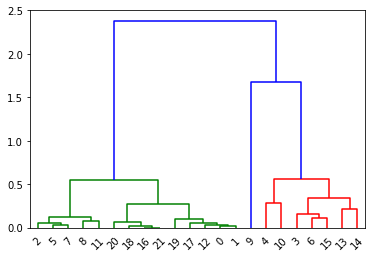

In [20]:
dendrogram = sch.dendrogram(hc)

En el dendrograma anterior existe la tentativa de indicar que la cantidad de cluster mas utiles es 3. se evaluara cual es el numero de cluster que reduce la suma cuadratica de los elementos a su respectivo centroide para verificar dicha hipótesis.

## Método del codo

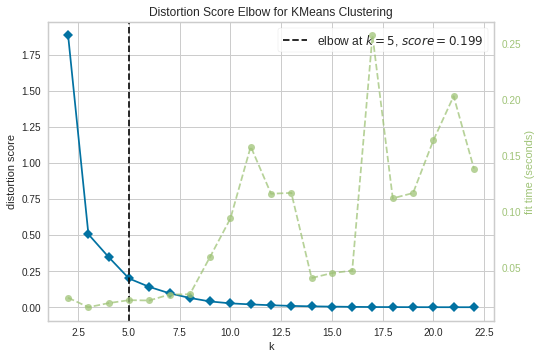

In [21]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model0 = KMeans()
visualizer = KElbowVisualizer(model0, k=(2,23), timings= True)
fit=df.sample(int(len(df_agrupa)*1))
visualizer.fit(df_agrupa)        
visualizer.show() 

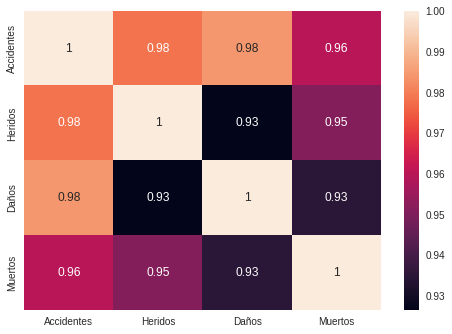

In [22]:
import seaborn as sb
corrMatrix=df_agrupa.corr()
sb.heatmap(corrMatrix, annot=True)
plt.show()

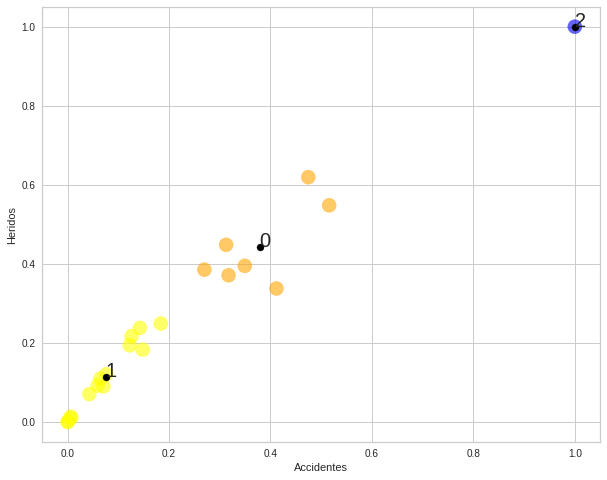

In [23]:
import matplotlib.pyplot as plt
import matplotlib
df_2D = df_agrupa[['Accidentes', 'Heridos']]
df_2D = np.array(df_2D)
kmeans_model_2D = KMeans(n_clusters=3, max_iter=1000).fit(df_2D)
labels_2D = kmeans_model_2D.labels_
centroids_2D = kmeans_model_2D.cluster_centers_

colors_k_means = ['orange','yellow','blue']
 
fig = plt.figure(figsize=(10, 8))
plt.scatter(df_2D[:, 0], df_2D[:, 1], c=labels_2D, s=200,
            cmap=matplotlib.colors.ListedColormap(colors_k_means), alpha=0.6)
plt.scatter(centroids_2D[:, 0], centroids_2D[:, 1], c='black', s=200, marker='.')
plt.xlabel('Accidentes')
plt.ylabel('Heridos')

for i in range(len(centroids_2D)):
    plt.annotate( i, (centroids_2D[i][0], centroids_2D[i][1]), fontsize=20)

In [24]:
distcentroide = []
k = range(1,18)
for i in k:
    
    kmeans = KMeans(n_clusters = i, random_state = 653)
    kmeans.fit(df_agrupa)
    distcentroide.append(kmeans.inertia_)


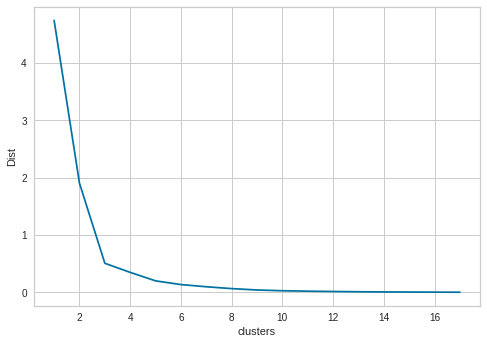

In [25]:
plt.plot(k,distcentroide)
plt.xlabel('clusters')
plt.ylabel('Dist')
plt.show()

Se observa que hay una flexión en k = 3

In [26]:
kmeans1 = KMeans(n_clusters = 3)
kmeans1.fit(df_agrupa)

KMeans(n_clusters=3)

In [27]:
df_agrupa['cluster'] = kmeans1.labels_

In [28]:
df = df_agrupa.reset_index()

In [29]:
df.head(10)

,NUMCOMUNA,Accidentes,Heridos,Daños,Muertos,cluster
0,1,0.064590,0.109449,0.027308,0.054054,0
1,2,0.059227,0.092135,0.031835,0.067568,0
2,3,0.142510,0.238103,0.063059,0.121622,0
3,4,0.269708,0.385485,0.173271,0.324324,1
4,5,0.474535,0.619351,0.353844,0.567568,1
5,6,0.126227,0.217318,0.050548,0.094595,0
6,7,0.312496,0.448270,0.199826,0.216216,1
7,8,0.122418,0.194175,0.062774,0.108108,0
8,9,0.184016,0.249117,0.130035,0.121622,0
9,10,1.000000,1.000000,1.000000,1.000000,2


Se vuelve a la escala original.

In [30]:
df[['Accidentes','Heridos','Daños','Muertos']] = scala.inverse_transform(df[['Accidentes','Heridos','Daños','Muertos']])

In [31]:
df.head()

,NUMCOMUNA,Accidentes,Heridos,Daños,Muertos,cluster
0,1,10.081967,7.549180,2.521858,0.010929,0
1,2,9.327869,6.445355,2.868852,0.013661,0
2,3,21.038251,15.751366,5.262295,0.024590,0
3,4,38.923497,25.147541,13.710383,0.065574,1
4,5,67.724044,40.057377,27.551913,0.114754,1


## Descripción de los cluster

In [32]:
df.groupby(['cluster']).mean()

,Accidentes,Heridos,Daños,Muertos
cluster,,,,
0,11.559746,7.815425,3.729543,0.014778
1,54.249415,28.854801,25.327088,0.067525
2,141.609290,64.325137,77.081967,0.202186


1 : Alto riesgo de accidentes y peligro. Peligro alto
2 : Peligro moderado. Peligro Medio
0 : Peligro bajo de accidentes. Peligro bajo
    

In [33]:
df.to_csv('cluster.csv', encoding = 'utf-8', index = False)

## Clustering por Barrio

In [34]:
df2 = pd.read_csv('Datafull.csv', encoding = 'utf-8')

In [35]:
df2.head()

,AÑO,CLASE_ACCIDENTE,DISEÑO,FECHA_ACCIDENTE,GRAVEDAD,MES,NUMCOMUNA,BARRIO,HORA,SEMANA,DIA_DEL_AÑO,DIA_DEL_MES,DIA_SEMANA,LONGITUD,ALTITUD,MOMENTO
0,2014,Otro,Tramo de via,2014-08-05,Con heridos,8,11,Los Conquistadores,07:15:00,Semana 32,217,5,Tuesday,-75.589313,6.239787,Mañana
1,2014,Choque,Interseccion,2014-08-05,Con heridos,8,5,Girardot,14:30:00,Semana 32,217,5,Tuesday,-75.570818,6.300041,Tarde
2,2014,Choque,Tramo de via,2014-08-05,Con heridos,8,14,Patio Bonito,15:50:00,Semana 32,217,5,Tuesday,-75.576574,6.208748,Tarde
3,2014,Otro,Tramo de via,2014-08-05,Con heridos,8,8,Villa Hermosa,13:00:00,Semana 32,217,5,Tuesday,-75.551255,6.259058,Tarde
4,2014,Choque,Tramo de via,2014-08-05,Con heridos,8,10,Los Ángeles,19:30:00,Semana 32,217,5,Tuesday,-75.556150,6.249966,Noche


In [36]:
df2 = df2[['BARRIO','DIA_DEL_MES','MES','GRAVEDAD']]

Al hacer una inspección de los datos se observa que hay barrios que difieren solo en una mayúscula o en un espacio por eso es necesario estandarizar los nombres, por lo tanto es necesario agregar una limpieza sobre los barrios.

In [37]:
df2['BARRIO'] = df2['BARRIO'].apply(lambda x : x.lower().replace(" ",""))

In [38]:
df2 = df2.groupby(['BARRIO','MES','DIA_DEL_MES'])['GRAVEDAD'].agg(([lambda x : x.count()  ,lambda x: ((x.__eq__('Con heridos')).sum()) , lambda x: ((x.__eq__('Solo daños')).sum()), lambda x: ((x.__eq__('Con muertos')).sum())]))

In [39]:
df2 = df2.groupby(['BARRIO']).mean()
df2.reset_index(inplace = True)
df2.rename({df2.columns[1] :'Accidentes', df2.columns[2] : 'Heridos', df2.columns[3]: 'Daños', df2.columns[4]: 'Muertos'}, axis = 1, inplace = True)

In [40]:
df2.head()

,BARRIO,Accidentes,Heridos,Daños,Muertos
0,aguasfrias,1.092105,0.815789,0.276316,0.000000
1,aldeapablovi,1.064103,0.833333,0.230769,0.000000
2,alejandroechavarría,3.099099,2.168168,0.924925,0.006006
3,alejandría,2.168385,0.680412,1.487973,0.000000
4,alfonsolópez,3.310541,2.324786,0.985755,0.000000


## Normalización

In [41]:
scala = preprocessing.MinMaxScaler().fit(df2[['Accidentes','Heridos','Daños','Muertos']])
df2[['Accidentes','Heridos','Daños','Muertos']] = preprocessing.MinMaxScaler().fit_transform(df2[['Accidentes','Heridos','Daños','Muertos']])


In [42]:
df2.head()

,BARRIO,Accidentes,Heridos,Daños,Muertos
0,aguasfrias,0.006111,0.119671,0.029502,0.000000
1,aldeapablovi,0.004253,0.122244,0.024639,0.000000
2,alejandroechavarría,0.139280,0.318056,0.098752,0.006006
3,alejandría,0.077525,0.099812,0.158868,0.000000
4,alfonsolópez,0.153310,0.341031,0.105247,0.000000


## Ordenamiento Jerárquico

In [43]:
df_agrupa = df2.set_index('BARRIO')
df_agrupa.head()

,Accidentes,Heridos,Daños,Muertos
BARRIO,,,,
aguasfrias,0.006111,0.119671,0.029502,0.000000
aldeapablovi,0.004253,0.122244,0.024639,0.000000
alejandroechavarría,0.139280,0.318056,0.098752,0.006006
alejandría,0.077525,0.099812,0.158868,0.000000
alfonsolópez,0.153310,0.341031,0.105247,0.000000


In [44]:
cluster_dist_matrix = distance_matrix(df_agrupa, df_agrupa)

In [45]:
cluster_dist_matrix = squareform(cluster_dist_matrix)
hc = sch.linkage(cluster_dist_matrix,method = 'ward')

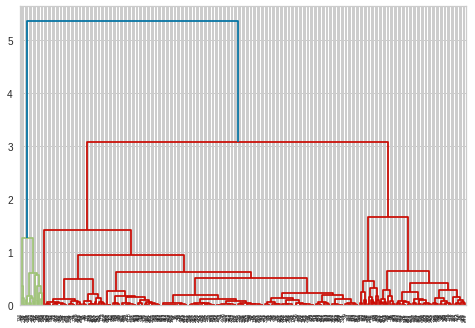

In [46]:
dendrogram = sch.dendrogram(hc)

En este caso no hay una intuición de cual es el agrupamiento mas útil. Por lo tanto se usa el método del codo para precisar en este sentido

## Método del codo

In [47]:
distcentroide = []
k = range(1,18)
for i in k:
    
    kmeans = KMeans(n_clusters = i, random_state = 653)
    kmeans.fit(df_agrupa)
    distcentroide.append(kmeans.inertia_)

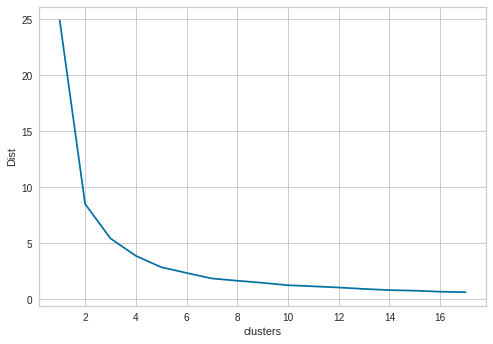

In [48]:
plt.plot(k,distcentroide)
plt.xlabel('clusters')
plt.ylabel('Dist')
plt.show()

En este caso se examinará la descripción del cluster con tres centroides

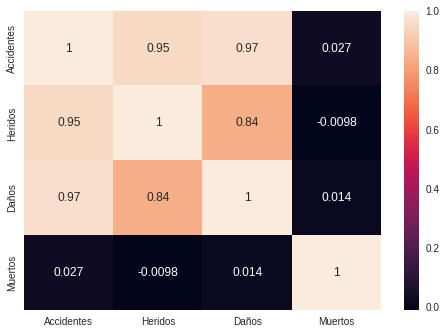

In [49]:
import seaborn as sb
corrMatrix=df_agrupa.corr()
sb.heatmap(corrMatrix, annot=True)
plt.show()

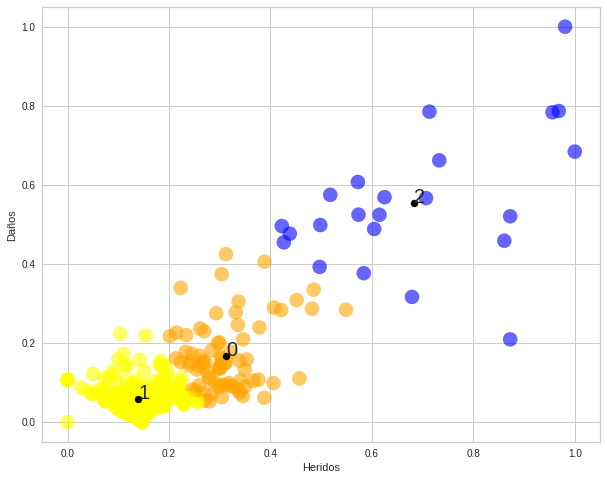

In [50]:
import matplotlib.pyplot as plt
import matplotlib
df_2D = df_agrupa[['Heridos', 'Daños']]
df_2D = np.array(df_2D)
kmeans_model_2D = KMeans(n_clusters=3, max_iter=1000).fit(df_2D)
labels_2D = kmeans_model_2D.labels_
centroids_2D = kmeans_model_2D.cluster_centers_

colors_k_means = ['orange','yellow','blue']
 
fig = plt.figure(figsize=(10, 8))
plt.scatter(df_2D[:, 0], df_2D[:, 1], c=labels_2D, s=200,
            cmap=matplotlib.colors.ListedColormap(colors_k_means), alpha=0.6)
plt.scatter(centroids_2D[:, 0], centroids_2D[:, 1], c='black', s=200, marker='.')
plt.xlabel('Heridos')
plt.ylabel('Daños')

for i in range(len(centroids_2D)):
    plt.annotate( i, (centroids_2D[i][0], centroids_2D[i][1]), fontsize=20)

In [51]:
kmeans1 = KMeans(n_clusters = 3)
kmeans1.fit(df_agrupa)

KMeans(n_clusters=3)

In [52]:
df_agrupa['cluster'] = kmeans1.labels_

In [53]:
df2 = df_agrupa.reset_index()

In [54]:
df2[['Accidentes','Heridos','Daños','Muertos']] = scala.inverse_transform(df2[['Accidentes','Heridos','Daños','Muertos']])

## Descripción del cluster por barrio

In [55]:
df2.groupby(['cluster']).mean()

,Accidentes,Heridos,Daños,Muertos
cluster,,,,
0,3.764383,2.134035,1.625078,0.005270
1,1.509506,0.962687,0.541051,0.005768
2,9.866409,4.658191,5.193836,0.014381


1 : Alto riesgo de accidentes y peligro. Peligro alto 2 : Peligro moderado. Peligro Medio 0 : Peligro bajo de accidentes. Peligro bajo

## Mapeo de puntos de cluster en el mapa geografico de Medellin 

In [57]:
! pip install geopandas 
import geopandas as gpd
df3=df2[['BARRIO','cluster']]
df_mapaMedellin=gpd.read_file('/content/drive/MyDrive/TAE Trabajo 1/Limite_Comuna_Corregimiento.geojson')

     |████████████████████████████████| 1.0 MB 4.8 MB/s 
     |████████████████████████████████| 6.3 MB 56.7 MB/s 
     |████████████████████████████████| 15.4 MB 52.8 MB/s 


In [141]:
df_puntos=pd.read_csv('Datafull.csv', encoding = 'utf-8')
df_puntos['BARRIO'] = df_puntos['BARRIO'].apply(lambda x : x.lower().replace(" ",""))
df_puntos=df_puntos[['BARRIO','LONGITUD','ALTITUD']]
Barrios=df_puntos['BARRIO'].unique()
len(Barrios)
Puntos_estrategicos=pd.DataFrame()
for i in Barrios:
  df_eliminados=df_puntos.loc[df_puntos["BARRIO"]==i]
  df_eliminados=df_eliminados.reset_index()
  Puntos_estrategicos=Puntos_estrategicos.append(df_eliminados.iloc[[0]])
Puntos_estrategicos=Puntos_estrategicos.sort_values('BARRIO')
Puntos_estrategicos=Puntos_estrategicos.set_index("BARRIO")
Puntos_estrategicos["cluster"]=df_agrupa["cluster"]
Puntos_estrategicos.head()

,index,LONGITUD,ALTITUD,cluster
BARRIO,,,,
aguasfrias,695,-75.624391,6.234261,1
aldeapablovi,7560,-75.543050,6.289770,1
alejandroechavarría,200,-75.544215,6.236333,0
alejandría,852,-75.571617,6.203436,1
alfonsolópez,711,-75.572187,6.282311,0


In [142]:
df_puntos1=pd.read_csv('Datafull.csv', encoding = 'utf-8')
df_puntos1=df_puntos1[['NUMCOMUNA','LONGITUD','ALTITUD']]
Barrios=df_puntos1['NUMCOMUNA'].unique()
len(Barrios)
Puntos_estrategicos1=pd.DataFrame()
for i in Barrios:
  df_eliminados=df_puntos1.loc[df_puntos1["NUMCOMUNA"]==i]
  df_eliminados=df_eliminados.reset_index()
  Puntos_estrategicos1=Puntos_estrategicos1.append(df_eliminados.iloc[[0]])
Puntos_estrategicos1

,index,NUMCOMUNA,LONGITUD,ALTITUD
0,0,11,-75.589313,6.239787
0,1,5,-75.570818,6.300041
0,2,14,-75.576574,6.208748
0,3,8,-75.551255,6.259058
0,4,10,-75.556150,6.249966
0,5,4,-75.555396,6.265270
0,7,3,-75.546693,6.279853
0,8,13,-75.617174,6.259676
0,10,16,-75.576531,6.231611
0,12,9,-75.566104,6.220597


In [114]:
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
geometry = [Point(xy) for xy in zip(Puntos_estrategicos["LONGITUD"], Puntos_estrategicos["ALTITUD"])]
df_mapa = Puntos_estrategicos.drop(['LONGITUD', 'ALTITUD'], axis=1)
df_mapa['CLUSTER']=Puntos_estrategicos['cluster']
#df_mapa['BARRIO']=Puntos_estrategicos['BARRIO']
gdf = GeoDataFrame(df_mapa, crs="EPSG:4326", geometry=geometry)
gdf

,index,cluster,CLUSTER,geometry
BARRIO,,,,
aguasfrias,695,1,1,POINT (-75.62439 6.23426)
aldeapablovi,7560,1,1,POINT (-75.54305 6.28977)
alejandroechavarría,200,0,0,POINT (-75.54422 6.23633)
alejandría,852,1,1,POINT (-75.57162 6.20344)
alfonsolópez,711,0,0,POINT (-75.57219 6.28231)
...,...,...,...,...
yolombo,54394,1,1,POINT (-75.60747 6.29661)
áreadeexpansiónaltavista,34095,1,1,POINT (-75.61406 6.22046)
áreadeexpansiónaltosdecalasanz,174,1,1,POINT (-75.60795 6.27349)


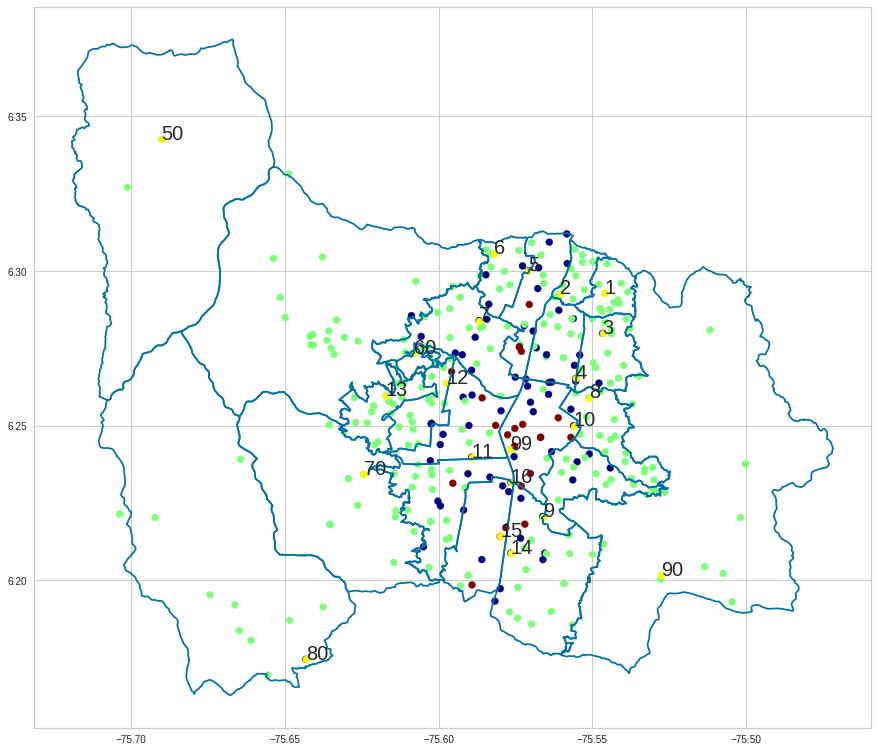

In [188]:
fig, ax = plt.subplots(figsize=(15, 15))
df_mapaMedellin.boundary.plot(ax=ax)
gdf.plot(column='CLUSTER',ax=ax,cmap='jet')
plt.scatter(Puntos_estrategicos1.iloc[:,2], Puntos_estrategicos1.iloc[:,3], c='Yellow', s=200, marker='.')
for i in range(len(Puntos_estrategicos1)):
  plt.annotate(str(Puntos_estrategicos1.iloc[i,1]),(Puntos_estrategicos1.iloc[i,2],Puntos_estrategicos1.iloc[i,3]),fontsize=20)
